# PDE-Learning of spin dynamics in XXZ model: Domain wall initial state at high temperature


In [53]:
%pylab inline
%load_ext autoreload
%autoreload 2

import sys
import time
import numpy as np 
sys.path.insert(0, "../")

from PDE_search import build_custom_Theta, BruteForceL0, TotalFiniteDiff_t, TotalFiniteDiff, build_Theta,\
TrainSTRidge, print_pde, build_linear_system, PolyDiff, TotalPolyDiff, FiniteDiff

from scipy.signal import savgol_filter
from utils import scalar_pde_solver, save_dict, load_dict, get_u_term_from_descr

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# In this example we consider evolution of a domain wall initial state in a ferromagnetic XXZ spin chain.
The Hamiltonian of the model reads:
$$ H = -\sum_i \left[ S^{x}_i S_{x+1} + S^y_{i} S^y_{i+1}+\Delta S^z_i S^z_{i+1} \right]$$

The initial state is prepared by combining left and right reservoirs  ($L$ and $R$) having opposite directions of the longitudinal magnetic field, so that the density matrix reads $\rho(t=0)=\rho_R \otimes \rho_L$, where  the thermal state for the right (left) subsystem is 
$$\rho_{R(L)} = \frac{1}{Z^{R(L)}}\exp{(\pm \mu \sum_{i\in {R (L)}} \sigma^z_{i})},$$ and $\mu\ll 1$  is  the inverse temperature of the initial Gibbs state.
For the mixed initial state, the spin dynamics is ballistic in the gapless phase $\Delta<1$, superdiffusive at the isotropic point $\Delta=1$,  and diffusive in the gapped phase $\Delta>1$. 

We define a rescaled longitudinal magnetization $u(t,x)=\langle S^z(t, x) \rangle/\mu$.

## First we perform PDE-learning of the magnetization dynamics in the gapped phase, $\Delta=2$

### Import and visualize data (tDMRG data from Ref. [1])

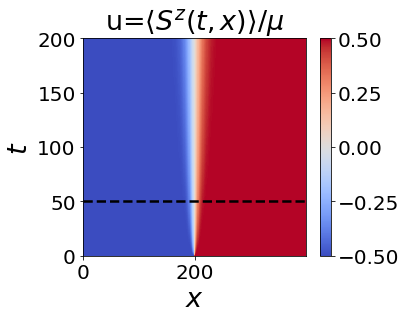

In [46]:
data_dict = load_dict('./data/highT_delta=2.npy')
# We truncate dataset by removing portion of the data at the beginning and the end of the evolution
start, stop = 250, -1
#########################

u = data_dict['u']
t = data_dict['t']
x = data_dict['x']

xx, tt = np.meshgrid(x, t)

plt.pcolormesh(xx, tt, u, cmap='coolwarm', rasterized=True)
plt.colorbar()

plt.xlabel(r'$x$')
plt.ylabel(r'$t$')

plt.hlines(t[start], x[0], x[-1], ls='--')
plt.title(r'u=$\langle S^z(t, x) \rangle/\mu$')

u = savgol_filter(u_orig, 31, 9, axis=1)
u = u[start:stop]
t = t[start:stop]

In [32]:
m, n = u.shape
dt = t[1]-t[0]
dx = x[1]-x[0]
print('Parameters of the dataset')
print('Nt, Nx: ', m, n)
print('Xmax, Tmax: ', x[-1], t[-1])
print('dt: ', dt, ' dx: ', dx)

Parameters of the dataset
Nt, Nx:  750 400
Xmax, Tmax:  399 199.79999999999453
dt:  0.19999999999999574  dx:  1


### Build Library of Candidate Terms

In [36]:
# Here we set open boundary conditions
bc = "open"
# Compute temporal derivative u_t from the data
ut = TotalFiniteDiff_t(u, dt).reshape((n*m,1))

# Define a list of candidate terms
descr = [
           'u_x',
           'u_x^2',
           'u*u_x', 
           'u^2*u_x', 
           'u^3*u_x',
           'u^4*u_x', 
           'u^5*u_x', 
           'u_xx',
           'u*u_xx',
           'u^2*u_xx',
           'u_xxx', 
           'u_xxxx', 
        ]

u_data = []
for term in descr:
    u_data.append(get_u_term_from_descr(term, u, x, bc).reshape((n*m,1)))

u_data = np.hstack(u_data)
Theta, descr = build_custom_Theta(u_data, descr)

In [37]:
print(f'Considering {len(descr)} candidate terms {descr}')

Considering 12 candidate terms ['u_x', 'u_x^2', 'u*u_x', 'u^2*u_x', 'u^3*u_x', 'u^4*u_x', 'u^5*u_x', 'u_xx', 'u*u_xx', 'u^2*u_xx', 'u_xxx', 'u_xxxx']


In [38]:
xi, _ = BruteForceL0(Theta, ut, descr, l0_penalty=1e-2, verbose=False)

Best PDE found with BruteForce:
u_t = (0.644549 -0.000000i)u_xx
   
Time elapsed (s): 1.9165208339691162


We recovered the diffusion equation
$u_t = D u_{xx}$

### Compare solution of inferred PDE with data for $\Delta=2$

In [39]:
# First, we specify the initial condition
u0 = u[0, :]
# Next, we solve the PDE
# (we freeze boundary conditions at the ends of the chain to avoid numerical instability)
u_pde = scalar_pde_solver(descr, xi, u0, t, x, bc="open", num_integrator_steps=25, 
                          fix_bndry=True, bndry_w=100, bndry_val_l=-0.5, bndry_val_r=0.5)

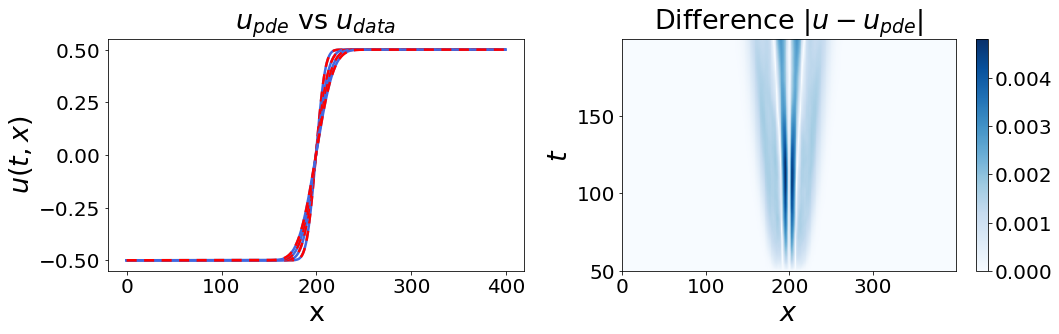

In [51]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5));

t_points = np.arange(0, 800, 200)
for it in t_points:
    ax[0].plot(u[it, :].real, c='royalblue', label='data')
    ax[0].plot(u_pde[it, :].real, ls='--', c='red', label='PDE', dashes=(4, 3))

ax[0].set_ylabel(r'$u(t,x)$')
ax[0].set_xlabel(r'x')
ax[0].set_title(r'$u_{pde}$ vs $u_{data}$')

xx, tt = np.meshgrid(x, t)
plt1 = ax[1].pcolormesh(xx, tt, abs(u-u_pde), cmap='Blues', rasterized=True)
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$t$')
ax[1].set_title(r'Difference $|u-u_{pde}|$')
fig.colorbar(plt1, ax=ax[1])
fig.tight_layout(pad=2)

# Now we consider Heisenberg model at the isotropic point, $\Delta=1$

### Import and visualize dataset (tDMRG data from Ref. [1])

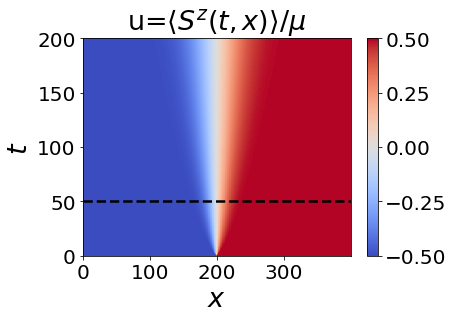

In [64]:
data_dict = load_dict('./data/highT_delta=1.npy')

start, stop = 250, -1

u = data_dict['u']
t = data_dict['t']
x = np.arange(u.shape[1])

xx, tt = np.meshgrid(x, t)

plt.pcolormesh(xx, tt, u, cmap='coolwarm', rasterized=True)
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')

plt.hlines(t[start], x[0], x[-1], ls='--')
plt.title(r'u=$\langle S^z(t, x) \rangle/\mu$')

###############################################
# Perform data pre-processing to smoothout spatial gradients
window_length = 31
polyorder = 7  # should be odd
u = savgol_filter(u, window_length, polyorder, axis=1)
###############################################

u = u[start:stop]
t = t[start:stop]

m, n = u.shape
dt = t[1]-t[0]
dx = x[1]-x[0]

In [65]:
# Compute temporal derivative u_t from the data
ut = TotalFiniteDiff_t(u, dt).reshape((n*m,1))

# Define a list of candidate terms
descr = [
           'u_x',
           'u*u_x', 
           'u^2*u_x', 
           'u^3*u_x',
           'u^4*u_x', 
           'u^5*u_x', 
           'u_xx', 
           'u_xxx', 
           'u_xxxx', 
        ]

u_data = []
for term in descr:
    u_data.append(get_u_term_from_descr(term, u, x, bc).reshape((n*m,1)))

u_data = np.hstack(u_data)
Theta, descr = build_custom_Theta(u_data, descr)

In [66]:
xi, _ = BruteForceL0(Theta, ut, descr, 
                     l0_penalty=1e-2, verbose=False, lhs_descr='u_t')

Best PDE found with BruteForce:
u_t = (-0.240794 +0.000000i)u*u_x
    + (1.893870 +0.000000i)u_xx
   
Time elapsed (s): 2.0417048931121826


The recovered PDE has the form 
$$u_t + a u u_x = D u_{xx},$$
which is a Burgers' equation. It can be interpreted as a noise-averaged stochastic Burgers' equation $u_t + a u u_x = D u_{xx} + \partial_x \eta (x, t)$, where $\eta(x, t)$ represents uncorrelated Gaussian noise, $\langle\eta (x,t)\rangle=0$.
Stochastic Burger's equation is equivalent to the 1D Kardar-Parizi-Zhang (KPZ) equation 
$$h_t +\frac{a}{2}(h_x)^2  = D h_{xx} + \eta(x,t)$$
via the substitution $u(t,x)=h_x(t,x)$. 

### Let's increase number of candidate terms and search for the PDE in the form $u_t = \partial_x J(u, u_x, \ldots)$

In [79]:
Jterms_descr = ['u', 'u^2', 'u^3', 'u^4', 'u^5',
                'u_x', 'u*u_x', 'u^2*u_x', 'u^3*u_x', 'u^4*u_x', 'u^5*u_x',
                'u_x^2', 'u_x^3', 'u_x^4', 'u_x^5',
               ]


Fterms_descr = ['Dx(' + term + ')' for term in Jterms_descr]
Fterms = [TotalFiniteDiff(get_u_term_from_descr(term, u, x, bc).reshape((m,n)), dx, 1, bc) for term in Jterms_descr]
Fterms = [term.reshape((n*m,1)) for term in Fterms]

u_data = np.hstack(Fterms)

Theta, Fdescr = build_custom_Theta(u_data, Fterms_descr)

In [78]:
print(f'Considering {len(Fdescr)} candidate terms: u_t =  {Fdescr}')

Considering 15 candidate terms: u_t =  ['Dx(u)', 'Dx(u^2)', 'Dx(u^3)', 'Dx(u^4)', 'Dx(u^5)', 'Dx(u_x)', 'Dx(u*u_x)', 'Dx(u^2*u_x)', 'Dx(u^3*u_x)', 'Dx(u^4*u_x)', 'Dx(u^5*u_x)', 'Dx(u_x^2)', 'Dx(u_x^3)', 'Dx(u_x^4)', 'Dx(u_x^5)']


In [81]:
BruteForceL0(Theta, ut, Fdescr, l0_penalty=1e-2, verbose=False, lhs_descr='u_t');

Best PDE found with BruteForce:
u_t = (-0.118413 +0.000000i)Dx(u^2)
    + (1.929069 +0.000000i)Dx(u_x)
   
Time elapsed (s): 31.81131100654602


We again recover the same Burger's-type equation!

### Compare solution of inferred PDE with data for $\Delta=1$

In [67]:
# First, we specify the initial condition
u0 = u[0, :]
# Next, we solve the PDE
# (we freeze boundary conditions at the edges to avoid numerical instability)
u_pde = scalar_pde_solver(descr, xi, u0, t, x, bc="open", num_integrator_steps=25, 
                          fix_bndry=True, bndry_w=10, bndry_val_l=-0.5, bndry_val_r=0.5)

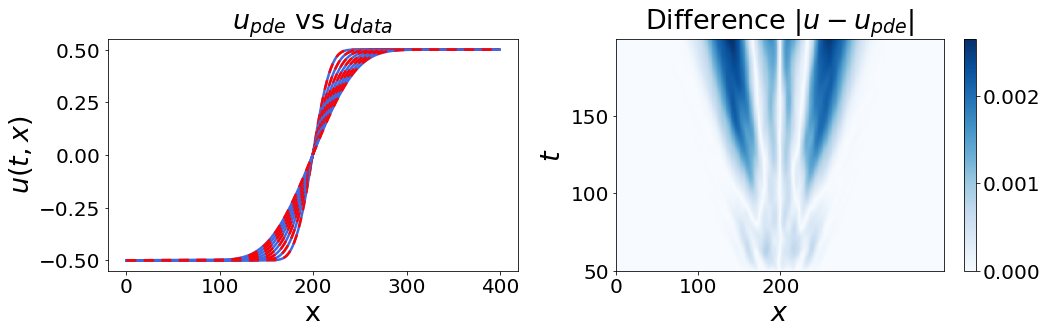

In [68]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5));

for it in np.arange(0, 800, 100):
    ax[0].plot(u[it, :].real, c='royalblue', label='data')
    ax[0].plot(u_pde[it, :].real, ls='--', c='red', label='PDE', dashes=(4, 3))
ax[0].set_ylabel(r'$u(t,x)$')
ax[0].set_xlabel(r'x')
ax[0].set_title(r'$u_{pde}$ vs $u_{data}$')

xx, tt = np.meshgrid(x, t)
plt1 = ax[1].pcolormesh(xx, tt, abs(u-u_pde), cmap='Blues', rasterized=True)
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$t$')
ax[1].set_title(r'Difference $|u-u_{pde}|$')
ax[1].set_xticks([0,100, 200])
fig.colorbar(plt1, ax=ax[1])
fig.tight_layout(pad=2)

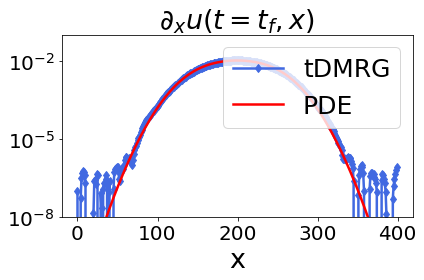

In [71]:
plt.plot(FiniteDiff(u[-1].real, dx, 1, bc='open'), label='tDMRG', c='royalblue', marker='d', ls='-')
plt.plot(FiniteDiff(u_pde[-1].real, dx, 1, bc='open'), label='PDE', c='red')
plt.yscale('log')
plt.title(r'$\partial_x u(t=t_f, x)$')
plt.xlabel(r'x')
plt.legend(loc=1)
plt.ylim(1e-8, 1e-1)
plt.tight_layout()

The agreement between tDMRG data and the solution of recovered the Burger's PDE is remarkable! 

## Bibliography
[1]  M.  Ljubotina,  M. Znidaric,  T.  Prosen,  "Kardar-Parisi-Zhang physics in the quantum Heisenberg magnet", Phys. Rev. Lett. **122**, 210602 (2019).

[2]  M.  Ljubotina,  M. Znidaric,  T.  Prosen,  "Spin  diffusion from an inhomogeneous quench in an integrable system", Nat. Commun. **8**, 1–6 (2017).

[3] S.  Gopalakrishnan,  R.  Vasseur,  "Kinetic  theory  of  spindiffusion  and  superdiffusion  in  XXZ  spin  chains", Phys. Rev. Lett. **122**, 127202 (2019).